### Arbitraje de precio con técnicas de aprendizaje automático de máquina: Deep Learning

En este notebook, desarrollaremos algunos modelos de Deep Learning con el objetivo de evaluar su rendimiento en términos de clasificación de las condiciones de arbitraje para nuestra base de datos de lags de precios. Al final, quisiéramos comparar los resultados contra los que obtivimos con el modelo de técnicas de Machine Learning, así que utilizaremos una base con 12 retrasos en los precios.

### Modelos

Utilizaremos tres arquitecturas distintas: Para la primera, el modelo utilizará capas de embedding con el objetivo de transformar las variables categórcas y ordinales en vectores continuos que puedan explicar mejor la incidencia de estas variables en las condiciones de arbitraje mediante relaciones de similaridad, las capas de embedding para las variables categóricas se concatenarán con la capa continua y al final se conectará con una capa densa con función de activación softmax de tres unidades para observar si se logra una clasificación adecuada de las condiciones de arbitraje. El entrenamiento de las capas de embedding se realiza al mismo tiempo que se entrena el modelo.  Para la segunda arquitectura, se utilizarán varias capas densas fully connected y para la tercera arquitectura, se utilizarán capas convolucionales y de max pooling. En ambos casos, la función de activación final será una función softmax de tres unidades y se entrenarán los modelos con las variables continuas.

### Imports

In [1]:
#Imports
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, Embedding, Input, Reshape, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
#from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline

pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Funcion para calcular y visualizar la matriz de confusion 
def plotCM(ytrue, ypred, clases=None, normalize = False, ax = None):
    """ Funcion para calcular y visualizar la matriz de confusion"""
    
    if clases == None:
        clases = list(set(ytrue))
        clases.sort() # etiquetas unicas ordenadas alfabeticamente
    
    CM = confusion_matrix(ytrue,ypred, labels=clases)
    
    #Normaliza la matriz de confusion dividiendo cada fila por el total de verdaderos
    if normalize:
        CM = 100*CM / CM.sum(axis=1).reshape(-1,1) #Aprovechando el Broadcasting!
 
    df = pd.DataFrame(CM, index=clases, columns=clases)
    df.index.name = 'True'; df.columns.name = 'Predicted'
    
    sns.heatmap( df, # Visualizando la matriz de confusion
             annot=True, fmt='2.1f', cmap='ocean_r',cbar=False,square=True, annot_kws={'fontsize':10}, ax=ax )
    
    plt.show()

In [3]:
#Lectura de la base datos original
base=pd.read_excel("arb.xlsx")

In [4]:
base.head(5)

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,USD_BID,USD_ASK,ASK_CIB,BID_CIB,ASK_PFB,BID_PFB,Spread_BE_SL,Spread_BL_SE,Arbitraje_BE_SL,Arbitraje_BL_SE
0,0,2022-01-03,9,54,9,False,False,0,0,1,...,4073.0000,4076.9000,31.7400,31.5500,32300,32010,-352.3238,-186.3012,0,0
1,1,2022-01-03,9,55,9,False,False,0,0,1,...,4072.7200,4076.0000,31.7500,31.5800,32300,32290,-75.3717,-157.9675,0,0
2,2,2022-01-03,9,56,9,False,False,0,0,1,...,4072.7200,4076.0000,31.7600,31.6000,32300,32290,-85.5630,-137.6064,0,0
3,3,2022-01-03,9,57,9,False,False,0,0,1,...,4072.7200,4075.0000,31.7600,31.6000,32300,32290,-77.6210,-137.6064,0,0
4,4,2022-01-03,9,58,9,False,False,0,0,1,...,4072.0000,4075.0000,31.7600,31.6200,32300,32290,-77.6210,-122.9355,0,0


In [5]:
base.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO',
       'CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE', 'Arbitraje_BE_SL', 'Arbitraje_BL_SE'],
      dtype='object')

In [6]:
#Definimos las columnas de precio (variables continuas)
columnas_precio=['CIB_close', 'COP_close', 'PFB_close', 'SPX_close', 'tasa_cambio',
       'USD_BID', 'USD_ASK', 'ASK_CIB', 'BID_CIB', 'ASK_PFB', 'BID_PFB',
       'Spread_BE_SL', 'Spread_BL_SE']

In [7]:
#Cremos la columna de Arbitraje
base['Arbitraje']=None
for i in range(len(base)):
        if base['Arbitraje_BE_SL'].iloc[i]==1: 
            base['Arbitraje'].iloc[i]=1
        elif base['Arbitraje_BL_SE'].iloc[i]==1:
            base['Arbitraje'].iloc[i]=2
        else:
            base['Arbitraje'].iloc[i]=0
    

C:\Users\fract\AppData\Local\Temp\ipykernel_11208\2445545036.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Arbitraje'].iloc[i]=0
C:\Users\fract\AppData\Local\Temp\ipykernel_11208\2445545036.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Arbitraje'].iloc[i]=2
C:\Users\fract\AppData\Local\Temp\ipykernel_11208\2445545036.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['Arbitraje'].iloc[i]=1


### Preprocesamiento Datos

A continuación creamos la base para 12 rezagos.

In [8]:
#Función para crear rezagos
def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)+'_'+str(ric)  # defines the column name
        df[col] = df[ric].shift(lag)  # creates the lagged data column
        cols.append(col)  # stores the column name
    df.dropna(inplace=True)  # gets rid of incomplete data rows
    return df, cols

In [9]:
#Función para crear una base con rezagos
def base_lags(base_all,lags):
    base_lags=add_lags(base_all,columnas_precio[0],lags)[0].iloc[:,1:]
    for column in columnas_precio[1:]:
        bse=add_lags(base_all,column,lags)[0].iloc[:,1:]
        base_lags=pd.concat([base_lags,bse],axis=1,join='outer')
        
    return pd.concat([base.iloc[lags:,:],base_lags],axis=1,join='outer')

In [10]:
#Base de datos con 12 rezagos
lags_12=base_lags(base,12)

In [11]:
lags_12.head()

,Unnamed: 0,Date,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,...,lag_3_Spread_BL_SE,lag_4_Spread_BL_SE,lag_5_Spread_BL_SE,lag_6_Spread_BL_SE,lag_7_Spread_BL_SE,lag_8_Spread_BL_SE,lag_9_Spread_BL_SE,lag_10_Spread_BL_SE,lag_11_Spread_BL_SE,lag_12_Spread_BL_SE
12,12,2022-01-03,10,6,10,False,False,0,0,1,...,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064,-157.9675,-186.3012
13,13,2022-01-03,10,7,10,False,False,0,0,1,...,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064,-157.9675
14,14,2022-01-03,10,8,10,False,False,0,0,1,...,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064
15,15,2022-01-03,10,9,10,False,False,0,0,1,...,-78.6455,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064
16,16,2022-01-03,10,10,10,False,False,0,0,1,...,-58.2880,-78.6455,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355


In [12]:
lags_12.columns

Index(['Unnamed: 0', 'Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO',
       ...
       'lag_3_Spread_BL_SE', 'lag_4_Spread_BL_SE', 'lag_5_Spread_BL_SE',
       'lag_6_Spread_BL_SE', 'lag_7_Spread_BL_SE', 'lag_8_Spread_BL_SE',
       'lag_9_Spread_BL_SE', 'lag_10_Spread_BL_SE', 'lag_11_Spread_BL_SE',
       'lag_12_Spread_BL_SE'],
      dtype='object', length=183)

In [13]:
# Definimos las variables categóricas
variables_categoricas=['Month','Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL',
       'Festivo_NYSE', 'Next_Day', 'Subasta', 'PFB_ABIERTO', 'CIB_ABIERTO']

In [14]:
#Variables que determinan el target y columnas que no utilizaremos en el entrenamiento
columnas_arb=['Arbitraje_BL_SE','Arbitraje_BE_SL','Arbitraje','Date']
cols_sobrantes=columnas_precio+columnas_arb

In [15]:
#Columnas que no utilizaremos porque reflejan condiciones actuales del mercado y no rezagos
cols_sobrantes

['CIB_close',
 'COP_close',
 'PFB_close',
 'SPX_close',
 'tasa_cambio',
 'USD_BID',
 'USD_ASK',
 'ASK_CIB',
 'BID_CIB',
 'ASK_PFB',
 'BID_PFB',
 'Spread_BE_SL',
 'Spread_BL_SE',
 'Arbitraje_BL_SE',
 'Arbitraje_BE_SL',
 'Arbitraje',
 'Date']

Teniendo en cuenta que los datos están desbalanceados, es posible que requiramos una estrategia de ponderación de los datos en el entrenamiento más adelante:

In [16]:
# Conteo de muestras por clase: 
classes_zero = lags_12[lags_12['Arbitraje'] == 0]
classes_one = lags_12[lags_12['Arbitraje'] == 1]
classes_two = lags_12[lags_12['Arbitraje'] == 2]

# convierte las muestras en NumPy arrays para el cómputo de la ponderación
zero_numpy = classes_zero['Arbitraje'].to_numpy()
one_numpy = classes_one['Arbitraje'].to_numpy()
two_numpy = classes_two['Arbitraje'].to_numpy()
all_together = np.concatenate((zero_numpy, one_numpy, two_numpy))
unique_classes = np.unique(all_together)

# Computamos los pesos para la ponderación de las clases de Arbitraje
weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=unique_classes, y=all_together)
print(weights)

[0.41041804 5.33778201 2.65875277]


In [17]:
#Seleccionamos los features
X=lags_12.drop(cols_sobrantes, axis=1)

In [18]:
X.head()

,Unnamed: 0,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO,...,lag_3_Spread_BL_SE,lag_4_Spread_BL_SE,lag_5_Spread_BL_SE,lag_6_Spread_BL_SE,lag_7_Spread_BL_SE,lag_8_Spread_BL_SE,lag_9_Spread_BL_SE,lag_10_Spread_BL_SE,lag_11_Spread_BL_SE,lag_12_Spread_BL_SE
12,12,10,6,10,False,False,0,0,1,1,...,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064,-157.9675,-186.3012
13,13,10,7,10,False,False,0,0,1,1,...,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064,-157.9675
14,14,10,8,10,False,False,0,0,1,1,...,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064,-137.6064
15,15,10,9,10,False,False,0,0,1,1,...,-78.6455,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355,-137.6064
16,16,10,10,10,False,False,0,0,1,1,...,-58.2880,-78.6455,33.9673,33.9673,-29.2522,-25.2895,-12.8650,-94.0900,-122.9355,-122.9355


In [19]:
#creamos la variable ordinal Month, para identificar el mes de la observación.
X['Month']=[lags_12['Date'].iloc[i].month for i in range(len(X))]

In [20]:
#Número de variables categóricas
len(variables_categoricas)

10

In [21]:
#Total de features
len(X.columns)

167

### Target

In [22]:
#Construimos el target
y_BL_SE=lags_12['Arbitraje_BL_SE']
y_BE_SL=lags_12['Arbitraje_BE_SL']
y_cat=[]
for i in range(len(X)):
    if y_BE_SL.loc[i+12]==1: 
        y_cat.append(1)
    elif y_BL_SE.loc[i+12]==1:
        y_cat.append(2)
    else:
        y_cat.append(0)


### Modelo para los embeddings

In [23]:
#Dividimos los datos en conjunto de entrenamiento y prueba
train_data, test_data, target_train, target_test = train_test_split(X, y_cat, test_size=0.3, random_state=None, stratify=y_cat,shuffle=True)

In [24]:
target_train=pd.DataFrame(target_train, index=train_data.index)

In [25]:
#Codificamos las variables categoricas de forma ordinal
train_test_var_categoricas = pd.concat([train_data[variables_categoricas], test_data[variables_categoricas]])

enc = OrdinalEncoder().fit(train_test_var_categoricas)
#Codificamos el conjunto de entrenamiento y el de prueba
train_data_var_categoricas = pd.DataFrame(enc.transform(train_data[variables_categoricas]),
                                       columns=variables_categoricas, index=train_data.index)
test_data_var_categoricas = pd.DataFrame(enc.transform(test_data[variables_categoricas]),
                                      columns=variables_categoricas, index=test_data.index)

In [26]:
train_test_var_categoricas.tail(10).index

Int64Index([17155, 33174, 9441, 30059, 2424, 16868, 34680, 38575, 42216,
            18090],
           dtype='int64')

In [27]:
#Observamos la coodificación para las variables categóricas
train_data_var_categoricas.head(10)

,Month,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO
7866,0.0000,7.0000,0.0000,7.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
16528,1.0000,7.0000,22.0000,7.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
9829,0.0000,3.0000,43.0000,3.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
30031,2.0000,7.0000,25.0000,8.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
38408,3.0000,3.0000,2.0000,4.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
15499,1.0000,8.0000,13.0000,8.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
18324,1.0000,1.0000,18.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3081,0.0000,8.0000,15.0000,8.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
14569,1.0000,1.0000,43.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
22825,2.0000,4.0000,19.0000,4.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000


In [28]:
#Extraemos el conjunto de validación - Utilizamos los datos del último mes como conjunto de validación
val_mask = train_data_var_categoricas.Month== (train_data_var_categoricas.Month.max())
train_mask=train_data.Month==(train_data.Month.max())

#No tomaremos en cuenta el mes en el conjunto de entrenamiento
drop_features = ['Month']


In [29]:
# Las entradas del modelo deben ser arrays
X_train = []
#Ordenamos los datos de validación y prueba
# Este loop sobre todas las variables categóricas crea un vector individual para cada una de las variables
# y las agrega a la lista
for cat in variables_categoricas:
    X_train.append(np.array(train_data_var_categoricas[~val_mask][cat]).reshape(-1,1))


In [30]:
#Observamos el conjunto de entrenamiento
train_data_var_categoricas[~val_mask]

,Month,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO
7866,0.0000,7.0000,0.0000,7.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
16528,1.0000,7.0000,22.0000,7.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000
9829,0.0000,3.0000,43.0000,3.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
30031,2.0000,7.0000,25.0000,8.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
38408,3.0000,3.0000,2.0000,4.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...
29058,2.0000,0.0000,12.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
43361,3.0000,4.0000,35.0000,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
37917,3.0000,3.0000,51.0000,4.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
13260,1.0000,6.0000,54.0000,6.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000


In [31]:
#Observamos el conjunto de validación
train_data_var_categoricas[val_mask]

,Month,Hora_COL,Minuto,Hora_NY,Festivo_COL,Festivo_NYSE,Next_Day,Subasta,PFB_ABIERTO,CIB_ABIERTO
48744,4.0000,4.0000,18.0000,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
49725,4.0000,2.0000,39.0000,3.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
49470,4.0000,7.0000,24.0000,8.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
47697,4.0000,4.0000,51.0000,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
48233,4.0000,4.0000,47.0000,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...,...,...
49576,4.0000,0.0000,10.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
49267,4.0000,4.0000,1.0000,5.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
46254,4.0000,7.0000,48.0000,8.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
47380,4.0000,8.0000,34.0000,9.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [32]:
#Extraemos los índicen del conjunto de entrenamiento y validación
indx_train=train_data[~train_mask].drop(drop_features + variables_categoricas, axis=1).index
indx_val=train_data[train_mask].drop(drop_features + variables_categoricas, axis=1).index

In [33]:
indx_train

Int64Index([ 7866, 16528,  9829, 30031, 38408, 15499, 18324,  3081, 14569,
            22825,
            ...
             9561, 14768, 20885, 38437,  7257, 29058, 43361, 37917, 13260,
            23056],
           dtype='int64', length=32018)

In [34]:
indx_train[0]

7866

In [35]:
# Agregamos las variables continuas al final de la lista de entrenamiento
train_norm=StandardScaler().fit_transform(train_data[~train_mask].drop(drop_features + variables_categoricas, axis=1))
X_train.append(train_norm)
y_train =target_train[~train_mask].values

#Repetimos el proceso para el conjunto de validación
X_val = []

for cat in variables_categoricas:
    X_val.append(np.array(train_data_var_categoricas[val_mask][cat]).reshape(-1,1))

val_norm=StandardScaler().fit_transform(train_data[train_mask].drop(drop_features + variables_categoricas, axis=1))    
X_val.append(val_norm)
y_val =target_train[train_mask].values

In [36]:
#Modificamos el tipo de datos para el conjunto de prueba
X_test=[]

for cat in variables_categoricas:
    X_test.append(np.array(test_data_var_categoricas[cat]).reshape(-1,1))
test_norm=StandardScaler().fit_transform(test_data.drop(variables_categoricas, axis=1))
X_test.append(test_norm)

In [37]:
#Observamos una muestra para le conjunto de entrenamiento
train_examples_2 = []
for data in X_train:
      train_examples_2.append(data[:2])

train_examples_2

[array([[0.],
        [1.]]),
 array([[7.],
        [7.]]),
 array([[ 0.],
        [22.]]),
 array([[7.],
        [7.]]),
 array([[0.],
        [0.]]),
 array([[0.],
        [0.]]),
 array([[1.],
        [1.]]),
 array([[0.],
        [0.]]),
 array([[1.],
        [1.]]),
 array([[1.],
        [1.]]),
 array([[-1.14059525, -0.67593296, -0.67590857, -0.66806066, -0.66540669,
         -0.66533742, -0.66269448, -0.66258885, -0.66251116, -0.66241237,
         -0.66236047, -0.6623118 , -0.65300552,  0.73416468,  0.73412462,
          0.73408691,  0.73401683,  0.73391968,  0.7337828 ,  0.73382007,
          0.7337587 ,  0.73366059,  0.73363733,  0.73361695,  0.73353279,
         -0.62866838, -0.62867801, -0.628595  , -0.62854941, -0.6285152 ,
         -0.58206177, -0.58198847, -0.581805  , -0.58172256, -0.58174949,
         -0.59243326, -0.59244471, -0.25867631, -0.23320735, -0.20394663,
         -0.19351107, -0.1947351 , -0.18685516, -0.19263201, -0.19204548,
         -0.16247138, -0.1476506

In [38]:
len(X_train[10])

32018

### Construcción del Modelo

In [39]:
#Recordamos las variables categóricas
variables_categoricas

['Month',
 'Hora_COL',
 'Minuto',
 'Hora_NY',
 'Festivo_COL',
 'Festivo_NYSE',
 'Next_Day',
 'Subasta',
 'PFB_ABIERTO',
 'CIB_ABIERTO']

In [40]:
#Extraemos las variables categóricas de interés
list(set(variables_categoricas).difference(set(drop_features)))

['Hora_COL',
 'CIB_ABIERTO',
 'Subasta',
 'Festivo_COL',
 'Minuto',
 'Festivo_NYSE',
 'Next_Day',
 'PFB_ABIERTO',
 'Hora_NY']

In [41]:
# limpiamos en el entorno para evitar conflictos con otras sesiones
tf.keras.backend.clear_session() 

In [42]:
#Función para construir las entradas para variables categóricas
def build_categorical_inputs(features):

    initial_inputs = {}
    cat_input_layers={}
    
    
    for feature in features:
        no_of_unique_cats  = train_test_var_categoricas[feature].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cats)/2), 50))
        categories  = no_of_unique_cats + 1

        initial_inputs[feature] = Input(shape=(1,))
        embedding_layer = Embedding(categories, 
                                    embedding_size,
                                    embeddings_regularizer=regularizers.l2(0.01),
                                    input_length=1)(initial_inputs[feature])
        cat_input_layers[feature] = Reshape(target_shape=(embedding_size,))(embedding_layer)

    return initial_inputs, cat_input_layers

In [43]:
#Observamos las entradas del modelo para las variables categóricas
build_categorical_inputs(variables_categoricas)

({'Month': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>,
  'Hora_COL': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_2')>,
  'Minuto': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_3')>,
  'Hora_NY': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_4')>,
  'Festivo_COL': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_5')>,
  'Festivo_NYSE': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_6')>,
  'Next_Day': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_7')>,
  'Subasta': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_8')>,
  'PFB_ABIERTO': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_9')>,
  'CIB_ABIERTO': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_10')>},
 {'Month': <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'reshape')>,
  'Hora_COL': <K

In [44]:
#Construimos el modelo basado en los embeddings de las variables categóricas, conectado al conjunto de variables continuas
def build_model():
  
    initial_inputs, input_layers = build_categorical_inputs(variables_categoricas)

    no_of_num_features = len(train_data.columns) - len(variables_categoricas) #- len(drop_features)
    
    initial_inputs['numerical_features'] = Input(shape=(no_of_num_features,))
    input_layers['numerical_features'] = initial_inputs['numerical_features']
    
    
    inputs = Concatenate(axis=-1)([layer for layer in input_layers.values()])
    
    
    drop_1_out = Dropout(0.1)(inputs)
    dense_1_out = Dense(1000, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_1_out)
    drop_2_out = Dropout(0.1)(dense_1_out)
    dense_2_out = Dense(500, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_2_out)
    drop_3_out = Dropout(0.1)(dense_2_out)
    dense_3_out = Dense(250, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_3_out)
    drop_4_out = Dropout(0.1)(dense_3_out)
    dense_4_out = Dense(125, activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01))(drop_4_out)
    
   
    #Adicionamos la capa final fully connected con tres unidades para la clasificación. Función de activación softmax
    final_out= Dense(
        units=3, name='fc_2',
        activation='softmax')(dense_4_out)
    
    model = keras.Model(inputs=[input for input in initial_inputs.values()],
                        outputs=final_out)

    #Compliamos el modelo con optimizador Adagrad, función de pérdida Sparse Categórical Cross entropu, metrica=Accuracy
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())
                          
    
    return model

model = build_model()


In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                              

 dense_1 (Dense)                (None, 500)          500500      ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 500)          0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 250)          125250      ['dropout_2[0][0]']              
                                                                                                  
 dropout_3 (Dropout)            (None, 250)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 125)          31375       ['dropout_3[0][0]']              
                                                                                                  
 fc_2 (Den

In [46]:
#Construimos un np Array paralos elementos del conjunto de entrenamiento y de prueba
training=np.zeros(len(X_train))
for data in X_train:
    np.append(data,training)

validation=np.zeros(len(X_val))
for data in X_val:
    np.append(data,validation)
                        

In [47]:
#X_train=training
y_train=np.array(y_train)
#X_val=validation
y_val=np.array(y_val)

In [48]:
# Entrenamos el modelo con 200 epochs y batch size de 300
history = model.fit([X_train[0],X_train[1],X_train[2],X_train[3],X_train[4],X_train[5],X_train[6],X_train[7],X_train[8],X_train[9],X_train[10]], y_train, 
                    batch_size=300,
                    epochs=250,
                    #class_weight={0:weights[0], 1:weights[1], 2:weights[2]},
                    validation_data =([X_val[0],X_val[1],X_val[2],X_val[3],X_val[4],X_val[5],X_val[6],X_val[7],X_val[8],X_val[9],X_val[10]], y_val),
                    #callbacks=[checkpoint, early_stop],
                    verbose=1)

Epoch 1/250
107/107 [==============================] - 6s 38ms/step - loss: 15.6406 - sparse_categorical_accuracy: 0.7939 - val_loss: 15.1854 - val_sparse_categorical_accuracy: 0.8876
Epoch 2/250
107/107 [==============================] - 5s 43ms/step - loss: 15.0379 - sparse_categorical_accuracy: 0.8045 - val_loss: 14.6628 - val_sparse_categorical_accuracy: 0.8876
Epoch 3/250
107/107 [==============================] - 4s 40ms/step - loss: 14.5151 - sparse_categorical_accuracy: 0.8047 - val_loss: 14.1525 - val_sparse_categorical_accuracy: 0.8876
Epoch 4/250
107/107 [==============================] - 4s 38ms/step - loss: 14.0116 - sparse_categorical_accuracy: 0.8048 - val_loss: 13.6677 - val_sparse_categorical_accuracy: 0.8876
Epoch 5/250
107/107 [==============================] - 4s 39ms/step - loss: 13.5199 - sparse_categorical_accuracy: 0.8056 - val_loss: 13.1887 - val_sparse_categorical_accuracy: 0.8876
Epoch 6/250
107/107 [==============================] - 5s 48ms/step - loss: 13.0

Epoch 46/250
107/107 [==============================] - 5s 47ms/step - loss: 2.8347 - sparse_categorical_accuracy: 0.8464 - val_loss: 2.7378 - val_sparse_categorical_accuracy: 0.8876
Epoch 47/250
107/107 [==============================] - 4s 42ms/step - loss: 2.7305 - sparse_categorical_accuracy: 0.8467 - val_loss: 2.6384 - val_sparse_categorical_accuracy: 0.8876
Epoch 48/250
107/107 [==============================] - 4s 41ms/step - loss: 2.6279 - sparse_categorical_accuracy: 0.8470 - val_loss: 2.5332 - val_sparse_categorical_accuracy: 0.8876
Epoch 49/250
107/107 [==============================] - 4s 41ms/step - loss: 2.5326 - sparse_categorical_accuracy: 0.8462 - val_loss: 2.4437 - val_sparse_categorical_accuracy: 0.8876
Epoch 50/250
107/107 [==============================] - 4s 40ms/step - loss: 2.4390 - sparse_categorical_accuracy: 0.8478 - val_loss: 2.3531 - val_sparse_categorical_accuracy: 0.8876
Epoch 51/250
107/107 [==============================] - 4s 41ms/step - loss: 2.3493 -

Epoch 91/250
107/107 [==============================] - 4s 41ms/step - loss: 0.8076 - sparse_categorical_accuracy: 0.8540 - val_loss: 0.7946 - val_sparse_categorical_accuracy: 0.8867
Epoch 92/250
107/107 [==============================] - 4s 40ms/step - loss: 0.7944 - sparse_categorical_accuracy: 0.8546 - val_loss: 0.7876 - val_sparse_categorical_accuracy: 0.8846
Epoch 93/250
107/107 [==============================] - 4s 39ms/step - loss: 0.7833 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.7779 - val_sparse_categorical_accuracy: 0.8839
Epoch 94/250
107/107 [==============================] - 4s 41ms/step - loss: 0.7713 - sparse_categorical_accuracy: 0.8547 - val_loss: 0.7655 - val_sparse_categorical_accuracy: 0.8809
Epoch 95/250
107/107 [==============================] - 4s 37ms/step - loss: 0.7627 - sparse_categorical_accuracy: 0.8541 - val_loss: 0.7572 - val_sparse_categorical_accuracy: 0.8803
Epoch 96/250
107/107 [==============================] - 4s 36ms/step - loss: 0.7519 -

107/107 [==============================] - 4s 35ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.8592 - val_loss: 0.5907 - val_sparse_categorical_accuracy: 0.8858
Epoch 136/250
107/107 [==============================] - 4s 35ms/step - loss: 0.5648 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.5921 - val_sparse_categorical_accuracy: 0.8839
Epoch 137/250
107/107 [==============================] - 4s 35ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.8584 - val_loss: 0.5884 - val_sparse_categorical_accuracy: 0.8830
Epoch 138/250
107/107 [==============================] - 4s 35ms/step - loss: 0.5616 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.5875 - val_sparse_categorical_accuracy: 0.8864
Epoch 139/250
107/107 [==============================] - 4s 35ms/step - loss: 0.5599 - sparse_categorical_accuracy: 0.8600 - val_loss: 0.5890 - val_sparse_categorical_accuracy: 0.8895
Epoch 140/250
107/107 [==============================] - 4s 36ms/step - loss: 0.5573 - sparse_

107/107 [==============================] - 4s 37ms/step - loss: 0.5148 - sparse_categorical_accuracy: 0.8628 - val_loss: 0.5612 - val_sparse_categorical_accuracy: 0.8588
Epoch 180/250
107/107 [==============================] - 4s 35ms/step - loss: 0.5133 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.5562 - val_sparse_categorical_accuracy: 0.8704
Epoch 181/250
107/107 [==============================] - 4s 36ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8640 - val_loss: 0.5581 - val_sparse_categorical_accuracy: 0.8649
Epoch 182/250
107/107 [==============================] - 4s 36ms/step - loss: 0.5120 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.5543 - val_sparse_categorical_accuracy: 0.8720
Epoch 183/250
107/107 [==============================] - 4s 36ms/step - loss: 0.5106 - sparse_categorical_accuracy: 0.8629 - val_loss: 0.5530 - val_sparse_categorical_accuracy: 0.8710
Epoch 184/250
107/107 [==============================] - 4s 36ms/step - loss: 0.5086 - sparse_

107/107 [==============================] - 4s 33ms/step - loss: 0.4894 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.5471 - val_sparse_categorical_accuracy: 0.8535
Epoch 224/250
107/107 [==============================] - 3s 33ms/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.5492 - val_sparse_categorical_accuracy: 0.8551
Epoch 225/250
107/107 [==============================] - 3s 32ms/step - loss: 0.4873 - sparse_categorical_accuracy: 0.8669 - val_loss: 0.5472 - val_sparse_categorical_accuracy: 0.8548
Epoch 226/250
107/107 [==============================] - 3s 33ms/step - loss: 0.4874 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.5487 - val_sparse_categorical_accuracy: 0.8557
Epoch 227/250
107/107 [==============================] - 3s 33ms/step - loss: 0.4879 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.5540 - val_sparse_categorical_accuracy: 0.8535
Epoch 228/250
107/107 [==============================] - 4s 33ms/step - loss: 0.4876 - sparse_

In [49]:
#Observamos los resultados del entrenamiento
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('model_history.csv', index=False)
hist

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,15.6406,0.7939,15.1854,0.8876,0
1,15.0379,0.8045,14.6628,0.8876,1
2,14.5151,0.8047,14.1525,0.8876,2
3,14.0116,0.8048,13.6677,0.8876,3
4,13.5199,0.8056,13.1887,0.8876,4
...,...,...,...,...,...
245,0.4798,0.8681,0.5559,0.8532,245
246,0.4796,0.8681,0.5534,0.8514,246
247,0.4789,0.8677,0.5637,0.8456,247
248,0.4775,0.8684,0.5585,0.8523,248


In [50]:
def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label='Val Error')  
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.plot(hist['epoch'], hist['sparse_categorical_accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_sparse_categorical_accuracy'],
           label='Val Accuracy')
    plt.legend()
    plt.show()


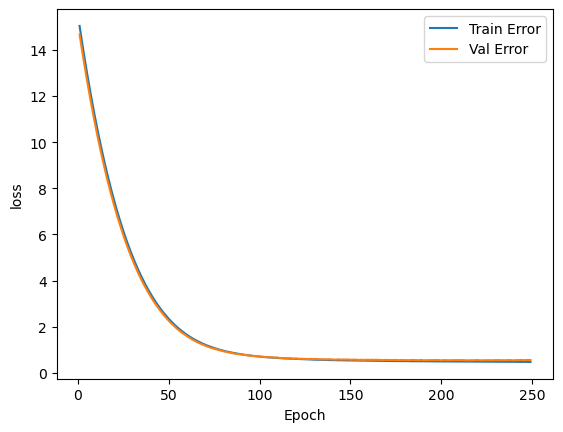

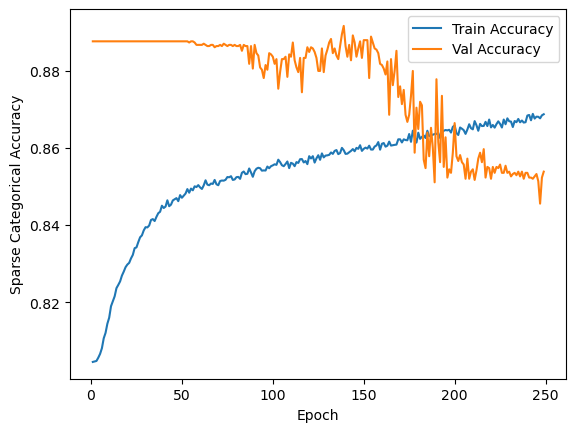

In [51]:
plot_history(hist.iloc[1:])


C:\Users\fract\AppData\Local\Temp\ipykernel_11208\416852573.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(X_test)


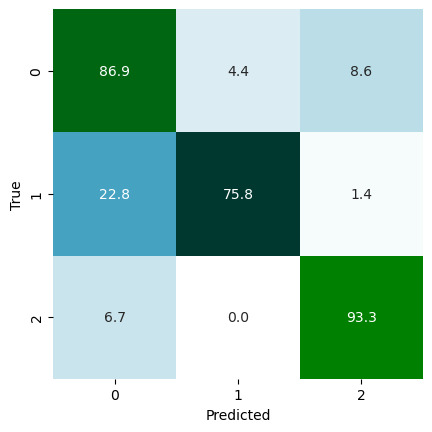

              precision    recall  f1-score   support

           0     0.8693    0.9880    0.9249     12279
           1     0.7576    0.3443    0.4734       944
           2     0.9332    0.3613    0.5209      1896

    accuracy                         0.8692     15119
   macro avg     0.8534    0.5645    0.6397     15119
weighted avg     0.8703    0.8692    0.8460     15119



In [52]:
predictions = model.predict_generator(X_test)

y_pred = np.argmax(predictions, axis=1)
y_real = target_test

matc=confusion_matrix(y_real, y_pred)

plotCM(y_pred, y_real, normalize=True)

print(classification_report(y_real,y_pred, digits = 4))

### Arquitectura con capas densas

Teniendo en cuenta los resultados obtenidos con el modelo de embeddings, realizamos el ejercicio,, pero esta vez sin incluir las variables categóricas en el entrenamiento.

In [53]:
columnas_fecha=['Date', 'Hora_COL', 'Minuto', 'Hora_NY', 'Festivo_COL', 'Festivo_NYSE', 'Next_Day', 'Subasta','PFB_ABIERTO',
'CIB_ABIERTO']
columnas_arb=['Arbitraje_BE_SL','Arbitraje_BL_SE','Arbitraje']
sobrantes=columnas_fecha+columnas_precio+columnas_arb

In [54]:
#Target
y_arb=lags_12['Arbitraje']

In [55]:
X=lags_12.drop(sobrantes, axis=1)
X_std=StandardScaler().fit_transform(X)

In [56]:
#Dividimos los datos en conjunto de entrenamiento y prueba
train_data, test_data, target_train, target_test = train_test_split(X_std, y_arb, test_size=0.3, random_state=None, stratify=y_arb,shuffle=True)


In [57]:
#Dividimos el conjunto de entrenamiento en validación y entrenamiento
X_train, X_val, y_train, y_val=train_test_split(train_data, target_train, test_size=0.1, random_state=None, stratify=target_train,shuffle=True)


In [58]:
#Creamos los tensores para el entrenamiento
train_data=tf.convert_to_tensor(train_data, dtype=np.float32)
test_data=tf.convert_to_tensor(test_data,dtype=np.float32)
target_train=np.array(target_train,dtype=np.float32)
target_test=np.array(target_test,dtype=np.float32)

X_train=tf.convert_to_tensor(X_train, dtype=np.float32)
X_val=tf.convert_to_tensor(X_val, dtype=np.float32)
y_train=np.array(y_train,dtype=np.float32)
y_val=np.array(y_val,dtype=np.float32)


Definimos un modelo simple de dos capas densas con una clasificación final dado por una capa densa de tres unidades.

In [59]:
def create_simple_nn():  
    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1],1), name="Input_layer"))
    model.add(Dense(1000, activation='relu', name="Hidden_layer_1"))
    model.add(Dense(500, activation='relu', name="Hidden_layer_2"))
    #model.add(Dense(250, activation='relu', name="Hidden_layer_3"))
    model.add(Dense(3, activation='softmax', name="Output_layer"))
    return model

In [60]:
#Compilamos el modelo
snn_model = create_simple_nn()  
snn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())  

In [61]:
snn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 157)               0         
                                                                 
 Hidden_layer_1 (Dense)      (None, 1000)              158000    
                                                                 
 Hidden_layer_2 (Dense)      (None, 500)               500500    
                                                                 
 Output_layer (Dense)        (None, 3)                 1503      
                                                                 
Total params: 660,003
Trainable params: 660,003
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = snn_model.fit(X_train,y_train, 
                    batch_size=200,
                    epochs=1000,
                    #class_weight={0:weights[0], 1:weights[1], 2:weights[2]},
                    validation_data =(X_val, y_val),
                    #callbacks=[checkpoint, early_stop],
                    verbose=1)

Epoch 1/1000
159/159 [==============================] - 3s 18ms/step - loss: 0.6699 - sparse_categorical_accuracy: 0.7768 - val_loss: 0.5407 - val_sparse_categorical_accuracy: 0.8124
Epoch 2/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.5218 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.5012 - val_sparse_categorical_accuracy: 0.8231
Epoch 3/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.4937 - sparse_categorical_accuracy: 0.8266 - val_loss: 0.4795 - val_sparse_categorical_accuracy: 0.8433
Epoch 4/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.4760 - sparse_categorical_accuracy: 0.8400 - val_loss: 0.4624 - val_sparse_categorical_accuracy: 0.8450
Epoch 5/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.4619 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.4491 - val_sparse_categorical_accuracy: 0.8450
Epoch 6/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.4505 -

159/159 [==============================] - 2s 13ms/step - loss: 0.3374 - sparse_categorical_accuracy: 0.8702 - val_loss: 0.3244 - val_sparse_categorical_accuracy: 0.8795
Epoch 46/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3362 - sparse_categorical_accuracy: 0.8710 - val_loss: 0.3232 - val_sparse_categorical_accuracy: 0.8798
Epoch 47/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.3230 - val_sparse_categorical_accuracy: 0.8804
Epoch 48/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3342 - sparse_categorical_accuracy: 0.8706 - val_loss: 0.3223 - val_sparse_categorical_accuracy: 0.8793
Epoch 49/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.3331 - sparse_categorical_accuracy: 0.8713 - val_loss: 0.3215 - val_sparse_categorical_accuracy: 0.8801
Epoch 50/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.3318 - sparse_

159/159 [==============================] - 2s 13ms/step - loss: 0.3031 - sparse_categorical_accuracy: 0.8813 - val_loss: 0.2930 - val_sparse_categorical_accuracy: 0.8878
Epoch 90/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3023 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.2926 - val_sparse_categorical_accuracy: 0.8878
Epoch 91/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3014 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.2913 - val_sparse_categorical_accuracy: 0.8878
Epoch 92/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3014 - sparse_categorical_accuracy: 0.8815 - val_loss: 0.2920 - val_sparse_categorical_accuracy: 0.8886
Epoch 93/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.2930 - val_sparse_categorical_accuracy: 0.8846
Epoch 94/1000
159/159 [==============================] - 2s 13ms/step - loss: 0.3008 - sparse_

159/159 [==============================] - 3s 16ms/step - loss: 0.2835 - sparse_categorical_accuracy: 0.8886 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.8923
Epoch 134/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2827 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.2783 - val_sparse_categorical_accuracy: 0.8906
Epoch 135/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.2760 - val_sparse_categorical_accuracy: 0.8914
Epoch 136/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2823 - sparse_categorical_accuracy: 0.8886 - val_loss: 0.2750 - val_sparse_categorical_accuracy: 0.8934
Epoch 137/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2819 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.2758 - val_sparse_categorical_accuracy: 0.8889
Epoch 138/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.2808 - sp

159/159 [==============================] - 2s 14ms/step - loss: 0.2693 - sparse_categorical_accuracy: 0.8923 - val_loss: 0.2638 - val_sparse_categorical_accuracy: 0.8957
Epoch 178/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2695 - sparse_categorical_accuracy: 0.8926 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.8951
Epoch 179/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2679 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.2624 - val_sparse_categorical_accuracy: 0.8957
Epoch 180/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2686 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.2623 - val_sparse_categorical_accuracy: 0.8965
Epoch 181/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2678 - sparse_categorical_accuracy: 0.8929 - val_loss: 0.2614 - val_sparse_categorical_accuracy: 0.8957
Epoch 182/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2677 - sp

159/159 [==============================] - 2s 14ms/step - loss: 0.2588 - sparse_categorical_accuracy: 0.8964 - val_loss: 0.2561 - val_sparse_categorical_accuracy: 0.8977
Epoch 222/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2584 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.2547 - val_sparse_categorical_accuracy: 0.8980
Epoch 223/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2581 - sparse_categorical_accuracy: 0.8960 - val_loss: 0.2550 - val_sparse_categorical_accuracy: 0.9002
Epoch 224/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2577 - sparse_categorical_accuracy: 0.8972 - val_loss: 0.2548 - val_sparse_categorical_accuracy: 0.8985
Epoch 225/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.2561 - val_sparse_categorical_accuracy: 0.8931
Epoch 226/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2581 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2502 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.2480 - val_sparse_categorical_accuracy: 0.8997
Epoch 266/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.2488 - val_sparse_categorical_accuracy: 0.9002
Epoch 267/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.2476 - val_sparse_categorical_accuracy: 0.9008
Epoch 268/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2501 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.2483 - val_sparse_categorical_accuracy: 0.8999
Epoch 269/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2499 - sparse_categorical_accuracy: 0.8997 - val_loss: 0.2515 - val_sparse_categorical_accuracy: 0.8971
Epoch 270/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2503 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2437 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.2458 - val_sparse_categorical_accuracy: 0.8957
Epoch 310/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2440 - sparse_categorical_accuracy: 0.9027 - val_loss: 0.2453 - val_sparse_categorical_accuracy: 0.9016
Epoch 311/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2438 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.2455 - val_sparse_categorical_accuracy: 0.8991
Epoch 312/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2434 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.2448 - val_sparse_categorical_accuracy: 0.9048
Epoch 313/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9031
Epoch 314/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2435 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2391 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.2427 - val_sparse_categorical_accuracy: 0.9045
Epoch 354/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2406 - val_sparse_categorical_accuracy: 0.9045
Epoch 355/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2387 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2422 - val_sparse_categorical_accuracy: 0.9028
Epoch 356/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.2421 - val_sparse_categorical_accuracy: 0.8997
Epoch 357/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2388 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.2435 - val_sparse_categorical_accuracy: 0.9065
Epoch 358/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2386 - sp

159/159 [==============================] - 2s 14ms/step - loss: 0.2346 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9053
Epoch 398/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2341 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.2368 - val_sparse_categorical_accuracy: 0.9050
Epoch 399/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2336 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.2379 - val_sparse_categorical_accuracy: 0.9045
Epoch 400/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2335 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.2355 - val_sparse_categorical_accuracy: 0.9056
Epoch 401/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2338 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.2362 - val_sparse_categorical_accuracy: 0.9048
Epoch 402/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2336 - sp

159/159 [==============================] - 2s 14ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9025
Epoch 442/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2301 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.2346 - val_sparse_categorical_accuracy: 0.9062
Epoch 443/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2305 - sparse_categorical_accuracy: 0.9077 - val_loss: 0.2354 - val_sparse_categorical_accuracy: 0.9019
Epoch 444/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2300 - sparse_categorical_accuracy: 0.9064 - val_loss: 0.2360 - val_sparse_categorical_accuracy: 0.9048
Epoch 445/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2295 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.2373 - val_sparse_categorical_accuracy: 0.9011
Epoch 446/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2297 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9089 - val_loss: 0.2335 - val_sparse_categorical_accuracy: 0.9065
Epoch 486/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2269 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.2336 - val_sparse_categorical_accuracy: 0.9062
Epoch 487/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2266 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2319 - val_sparse_categorical_accuracy: 0.9073
Epoch 488/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2267 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.2322 - val_sparse_categorical_accuracy: 0.9070
Epoch 489/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9091 - val_loss: 0.2309 - val_sparse_categorical_accuracy: 0.9079
Epoch 490/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2261 - sp

159/159 [==============================] - 3s 16ms/step - loss: 0.2231 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.2332 - val_sparse_categorical_accuracy: 0.9048
Epoch 530/1000
159/159 [==============================] - 3s 17ms/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2315 - val_sparse_categorical_accuracy: 0.9084
Epoch 531/1000
159/159 [==============================] - 3s 17ms/step - loss: 0.2234 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.2357 - val_sparse_categorical_accuracy: 0.9016
Epoch 532/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2240 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9079
Epoch 533/1000
159/159 [==============================] - 3s 17ms/step - loss: 0.2235 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9073
Epoch 534/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2240 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2206 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.2298 - val_sparse_categorical_accuracy: 0.9065
Epoch 574/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2215 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.2298 - val_sparse_categorical_accuracy: 0.9076
Epoch 575/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2216 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.2277 - val_sparse_categorical_accuracy: 0.9059
Epoch 576/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2205 - sparse_categorical_accuracy: 0.9105 - val_loss: 0.2297 - val_sparse_categorical_accuracy: 0.9014
Epoch 577/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2200 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9070
Epoch 578/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2208 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.2270 - val_sparse_categorical_accuracy: 0.9079
Epoch 618/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9125 - val_loss: 0.2287 - val_sparse_categorical_accuracy: 0.9025
Epoch 619/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2190 - sparse_categorical_accuracy: 0.9110 - val_loss: 0.2319 - val_sparse_categorical_accuracy: 0.9079
Epoch 620/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2177 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.2260 - val_sparse_categorical_accuracy: 0.9084
Epoch 621/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2179 - sparse_categorical_accuracy: 0.9113 - val_loss: 0.2292 - val_sparse_categorical_accuracy: 0.9002
Epoch 622/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2178 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9129 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9110
Epoch 662/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2162 - sparse_categorical_accuracy: 0.9122 - val_loss: 0.2251 - val_sparse_categorical_accuracy: 0.9084
Epoch 663/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9126 - val_loss: 0.2274 - val_sparse_categorical_accuracy: 0.9056
Epoch 664/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2155 - sparse_categorical_accuracy: 0.9124 - val_loss: 0.2271 - val_sparse_categorical_accuracy: 0.9053
Epoch 665/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2158 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.2248 - val_sparse_categorical_accuracy: 0.9087
Epoch 666/1000
159/159 [==============================] - 2s 16ms/step - loss: 0.2160 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2138 - sparse_categorical_accuracy: 0.9131 - val_loss: 0.2239 - val_sparse_categorical_accuracy: 0.9093
Epoch 706/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2132 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.2239 - val_sparse_categorical_accuracy: 0.9096
Epoch 707/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2130 - sparse_categorical_accuracy: 0.9130 - val_loss: 0.2231 - val_sparse_categorical_accuracy: 0.9104
Epoch 708/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.2135 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.2246 - val_sparse_categorical_accuracy: 0.9104
Epoch 709/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2132 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.2232 - val_sparse_categorical_accuracy: 0.9113
Epoch 710/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2131 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2116 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.2207 - val_sparse_categorical_accuracy: 0.9096
Epoch 750/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2116 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.2245 - val_sparse_categorical_accuracy: 0.9084
Epoch 751/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2110 - sparse_categorical_accuracy: 0.9148 - val_loss: 0.2233 - val_sparse_categorical_accuracy: 0.9070
Epoch 752/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9128 - val_loss: 0.2216 - val_sparse_categorical_accuracy: 0.9096
Epoch 753/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2111 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9104
Epoch 754/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2109 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2094 - sparse_categorical_accuracy: 0.9151 - val_loss: 0.2199 - val_sparse_categorical_accuracy: 0.9099
Epoch 794/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2100 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9107
Epoch 795/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2093 - sparse_categorical_accuracy: 0.9146 - val_loss: 0.2188 - val_sparse_categorical_accuracy: 0.9116
Epoch 796/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2102 - sparse_categorical_accuracy: 0.9137 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9065
Epoch 797/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9145 - val_loss: 0.2189 - val_sparse_categorical_accuracy: 0.9127
Epoch 798/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2095 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2182 - val_sparse_categorical_accuracy: 0.9093
Epoch 838/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2081 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2196 - val_sparse_categorical_accuracy: 0.9121
Epoch 839/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2080 - sparse_categorical_accuracy: 0.9144 - val_loss: 0.2245 - val_sparse_categorical_accuracy: 0.9090
Epoch 840/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2077 - sparse_categorical_accuracy: 0.9155 - val_loss: 0.2200 - val_sparse_categorical_accuracy: 0.9101
Epoch 841/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2078 - sparse_categorical_accuracy: 0.9152 - val_loss: 0.2240 - val_sparse_categorical_accuracy: 0.9050
Epoch 842/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2081 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2069 - sparse_categorical_accuracy: 0.9138 - val_loss: 0.2201 - val_sparse_categorical_accuracy: 0.9118
Epoch 882/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.2057 - sparse_categorical_accuracy: 0.9164 - val_loss: 0.2298 - val_sparse_categorical_accuracy: 0.9045
Epoch 883/1000
159/159 [==============================] - 3s 19ms/step - loss: 0.2084 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.2218 - val_sparse_categorical_accuracy: 0.9056
Epoch 884/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2066 - sparse_categorical_accuracy: 0.9149 - val_loss: 0.2198 - val_sparse_categorical_accuracy: 0.9099
Epoch 885/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.2059 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.2177 - val_sparse_categorical_accuracy: 0.9079
Epoch 886/1000
159/159 [==============================] - 3s 16ms/step - loss: 0.2062 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2038 - sparse_categorical_accuracy: 0.9171 - val_loss: 0.2149 - val_sparse_categorical_accuracy: 0.9113
Epoch 926/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2040 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.2190 - val_sparse_categorical_accuracy: 0.9104
Epoch 927/1000
159/159 [==============================] - 2s 14ms/step - loss: 0.2043 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.2166 - val_sparse_categorical_accuracy: 0.9053
Epoch 928/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2045 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.2158 - val_sparse_categorical_accuracy: 0.9130
Epoch 929/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.2177 - val_sparse_categorical_accuracy: 0.9056
Epoch 930/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2046 - sp

159/159 [==============================] - 2s 15ms/step - loss: 0.2026 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.2159 - val_sparse_categorical_accuracy: 0.9127
Epoch 970/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2036 - sparse_categorical_accuracy: 0.9166 - val_loss: 0.2166 - val_sparse_categorical_accuracy: 0.9065
Epoch 971/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2035 - sparse_categorical_accuracy: 0.9164 - val_loss: 0.2160 - val_sparse_categorical_accuracy: 0.9110
Epoch 972/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2023 - sparse_categorical_accuracy: 0.9168 - val_loss: 0.2161 - val_sparse_categorical_accuracy: 0.9116
Epoch 973/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2034 - sparse_categorical_accuracy: 0.9162 - val_loss: 0.2142 - val_sparse_categorical_accuracy: 0.9130
Epoch 974/1000
159/159 [==============================] - 2s 15ms/step - loss: 0.2027 - sp

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('model_history.csv', index=False)
hist

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,0.6699,0.7768,0.5407,0.8124,0
1,0.5218,0.8123,0.5012,0.8231,1
2,0.4937,0.8266,0.4795,0.8433,2
3,0.4760,0.8400,0.4624,0.8450,3
4,0.4619,0.8415,0.4491,0.8450,4
...,...,...,...,...,...
995,0.2014,0.9171,0.2168,0.9110,995
996,0.2017,0.9173,0.2156,0.9059,996
997,0.2019,0.9176,0.2233,0.9070,997
998,0.2023,0.9165,0.2154,0.9130,998


In [64]:
def plot_history(hist):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label='Val Error')  
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.plot(hist['epoch'], hist['sparse_categorical_accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_sparse_categorical_accuracy'],
           label='Val Accuracy')
    plt.legend()
    plt.show()

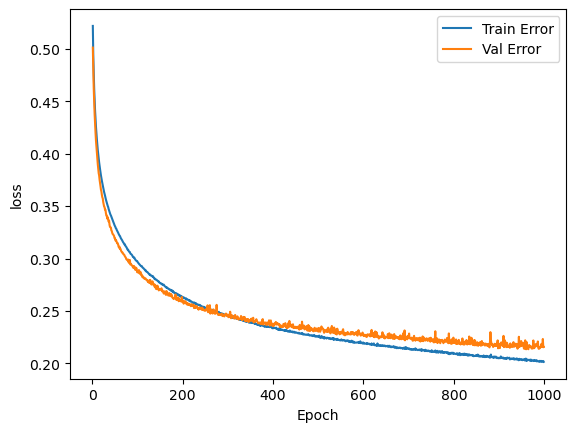

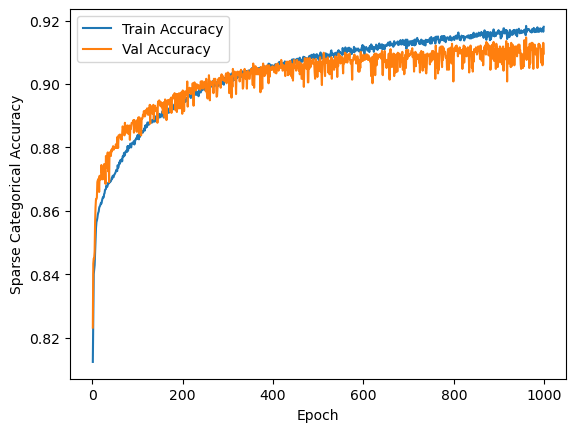

In [65]:
#Graficamos los resultados del entrenamiento
plot_history(hist.iloc[1:])

C:\Users\fract\AppData\Local\Temp\ipykernel_11208\1036272386.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = snn_model.predict_generator(test_data)


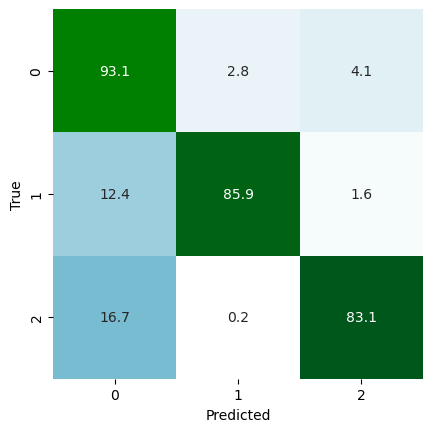

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     12279
         1.0       0.86      0.62      0.72       944
         2.0       0.83      0.72      0.77      1896

    accuracy                           0.92     15119
   macro avg       0.87      0.77      0.81     15119
weighted avg       0.91      0.92      0.91     15119



In [66]:
#Realizamos predicción y hacemos un print del classification report
predictions = snn_model.predict_generator(test_data)

y_pred = np.argmax(predictions, axis=1)
y_real = np.array(target_test)

matc=confusion_matrix(y_real, y_pred)

plotCM(y_pred, y_real, normalize=True)

print(classification_report(y_real,y_pred))

### Modelo Convolucional

In [67]:
#Definimos el modelo convolucional.(Algunas capas están comentadas con # porque se probaron también para el entrenamiento.)
def create_conv_model():  
    model = Sequential()
    model.add(Flatten(input_shape=(train_data.shape[1],1), name="Input_layer"))
    #Add convolutional layer
    model.add(Reshape(target_shape=(1,157)))
    
    model.add(tf.keras.layers.Conv1D(
        filters=128, kernel_size=5,
        strides=1, padding='same',
        data_format='channels_last',
        name='conv_1', activation='relu'))

    #Add Max pooling layer
    model.add(tf.keras.layers.MaxPooling1D(
        pool_size=3, padding='same',name='pool_1'))

    #Add convolutional layer    
    model.add(tf.keras.layers.Conv1D(
        filters=64, kernel_size=5,
        strides=1, padding='same',
        name='conv_3', activation='relu'))
    
    #Add Max pooling layer
    model.add(tf.keras.layers.MaxPooling1D(
        pool_size=3, padding='same',name='pool_3'))

    #Add convolutional layer    
    #model.add(tf.keras.layers.Conv1D(
        #filters=64, kernel_size=3,
        #strides=1, padding='same',
        #name='conv_2', activation='relu'))

    #Add Max pooling layer
   # model.add(tf.keras.layers.MaxPooling1D(pool_size=2,padding='same', name='pool_4'))
    
    #Add convolutional layer    
   # model.add(tf.keras.layers.Conv1D(
        #filters=64, kernel_size=3,
        #strides=1, padding='same',
        #name='conv_4', activation='relu'))

    #Add Max pooling layer
    #model.add(tf.keras.layers.MaxPooling1D(pool_size=2,padding='same', name='pool_5'))

    #Add Flatten Layer
    model.add(tf.keras.layers.Flatten())

    #Add the Fully COnnected network
    model.add(tf.keras.layers.Dense(
        units=1024, name='fc_1', 
        activation='relu'))

    model.add(tf.keras.layers.Dropout(
        rate=0.5))

    model.add(tf.keras.layers.Dense(
        units=3, name='fc_2',
        activation='softmax'))

    return model

In [68]:
conv_model = create_conv_model()  
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())  

In [69]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (Flatten)       (None, 157)               0         
                                                                 
 reshape_20 (Reshape)        (None, 1, 157)            0         
                                                                 
 conv_1 (Conv1D)             (None, 1, 128)            100608    
                                                                 
 pool_1 (MaxPooling1D)       (None, 1, 128)            0         
                                                                 
 conv_3 (Conv1D)             (None, 1, 64)             41024     
                                                                 
 pool_3 (MaxPooling1D)       (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)               

In [70]:
history = conv_model.fit(X_train,y_train, 
                    batch_size=100,
                    epochs=700,
                    #class_weight={0:weights[0], 1:weights[1], 2:weights[2]},
                    validation_data =(X_val, y_val),
                    #callbacks=[checkpoint, early_stop],
                    verbose=1)

Epoch 1/700
318/318 [==============================] - 4s 9ms/step - loss: 0.9039 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.7055 - val_sparse_categorical_accuracy: 0.8124
Epoch 2/700
318/318 [==============================] - 2s 7ms/step - loss: 0.6359 - sparse_categorical_accuracy: 0.8122 - val_loss: 0.5890 - val_sparse_categorical_accuracy: 0.8124
Epoch 3/700
318/318 [==============================] - 2s 7ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.8122 - val_loss: 0.5547 - val_sparse_categorical_accuracy: 0.8124
Epoch 4/700
318/318 [==============================] - 2s 7ms/step - loss: 0.5493 - sparse_categorical_accuracy: 0.8122 - val_loss: 0.5365 - val_sparse_categorical_accuracy: 0.8124
Epoch 5/700
318/318 [==============================] - 2s 8ms/step - loss: 0.5338 - sparse_categorical_accuracy: 0.8123 - val_loss: 0.5236 - val_sparse_categorical_accuracy: 0.8124
Epoch 6/700
318/318 [==============================] - 2s 7ms/step - loss: 0.5216 - sparse_cate

318/318 [==============================] - 2s 7ms/step - loss: 0.3671 - sparse_categorical_accuracy: 0.8648 - val_loss: 0.3522 - val_sparse_categorical_accuracy: 0.8741
Epoch 47/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3661 - sparse_categorical_accuracy: 0.8650 - val_loss: 0.3513 - val_sparse_categorical_accuracy: 0.8733
Epoch 48/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3643 - sparse_categorical_accuracy: 0.8653 - val_loss: 0.3498 - val_sparse_categorical_accuracy: 0.8750
Epoch 49/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8652 - val_loss: 0.3504 - val_sparse_categorical_accuracy: 0.8753
Epoch 50/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3624 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8741
Epoch 51/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3616 - sparse_categorical

318/318 [==============================] - 2s 7ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.3115 - val_sparse_categorical_accuracy: 0.8753
Epoch 92/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3228 - sparse_categorical_accuracy: 0.8721 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.8807
Epoch 93/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3206 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.3088 - val_sparse_categorical_accuracy: 0.8815
Epoch 94/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3213 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.3085 - val_sparse_categorical_accuracy: 0.8795
Epoch 95/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3208 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.3079 - val_sparse_categorical_accuracy: 0.8787
Epoch 96/700
318/318 [==============================] - 2s 7ms/step - loss: 0.3200 - sparse_categorical

Epoch 136/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2952 - sparse_categorical_accuracy: 0.8804 - val_loss: 0.2843 - val_sparse_categorical_accuracy: 0.8866
Epoch 137/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2943 - sparse_categorical_accuracy: 0.8816 - val_loss: 0.2835 - val_sparse_categorical_accuracy: 0.8883
Epoch 138/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2940 - sparse_categorical_accuracy: 0.8818 - val_loss: 0.2841 - val_sparse_categorical_accuracy: 0.8818
Epoch 139/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2939 - sparse_categorical_accuracy: 0.8805 - val_loss: 0.2816 - val_sparse_categorical_accuracy: 0.8872
Epoch 140/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2929 - sparse_categorical_accuracy: 0.8821 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.8872
Epoch 141/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2931 -

Epoch 181/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2761 - sparse_categorical_accuracy: 0.8893 - val_loss: 0.2671 - val_sparse_categorical_accuracy: 0.8934
Epoch 182/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2759 - sparse_categorical_accuracy: 0.8908 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.8903
Epoch 183/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2759 - sparse_categorical_accuracy: 0.8902 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.8892
Epoch 184/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2759 - sparse_categorical_accuracy: 0.8890 - val_loss: 0.2730 - val_sparse_categorical_accuracy: 0.8903
Epoch 185/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2760 - sparse_categorical_accuracy: 0.8901 - val_loss: 0.2665 - val_sparse_categorical_accuracy: 0.8914
Epoch 186/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2753 -

Epoch 226/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2647 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.2569 - val_sparse_categorical_accuracy: 0.8943
Epoch 227/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2645 - sparse_categorical_accuracy: 0.8930 - val_loss: 0.2568 - val_sparse_categorical_accuracy: 0.8906
Epoch 228/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2642 - sparse_categorical_accuracy: 0.8946 - val_loss: 0.2574 - val_sparse_categorical_accuracy: 0.8954
Epoch 229/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2641 - sparse_categorical_accuracy: 0.8936 - val_loss: 0.2560 - val_sparse_categorical_accuracy: 0.8937
Epoch 230/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2637 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.2576 - val_sparse_categorical_accuracy: 0.8897
Epoch 231/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2641 -

Epoch 271/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2561 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.2493 - val_sparse_categorical_accuracy: 0.8957
Epoch 272/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2551 - sparse_categorical_accuracy: 0.8970 - val_loss: 0.2493 - val_sparse_categorical_accuracy: 0.8991
Epoch 273/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2547 - sparse_categorical_accuracy: 0.8967 - val_loss: 0.2500 - val_sparse_categorical_accuracy: 0.8974
Epoch 274/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.2491 - val_sparse_categorical_accuracy: 0.8977
Epoch 275/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2545 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.2472 - val_sparse_categorical_accuracy: 0.9014
Epoch 276/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2545 -

Epoch 316/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2477 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.2471 - val_sparse_categorical_accuracy: 0.9005
Epoch 317/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2473 - sparse_categorical_accuracy: 0.8998 - val_loss: 0.2433 - val_sparse_categorical_accuracy: 0.9011
Epoch 318/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2476 - sparse_categorical_accuracy: 0.9002 - val_loss: 0.2460 - val_sparse_categorical_accuracy: 0.8999
Epoch 319/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2486 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9005
Epoch 320/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2472 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.2425 - val_sparse_categorical_accuracy: 0.9008
Epoch 321/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2479 -

Epoch 361/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9020 - val_loss: 0.2399 - val_sparse_categorical_accuracy: 0.9014
Epoch 362/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2421 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.2409 - val_sparse_categorical_accuracy: 0.8988
Epoch 363/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.2395 - val_sparse_categorical_accuracy: 0.9019
Epoch 364/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2412 - sparse_categorical_accuracy: 0.9024 - val_loss: 0.2423 - val_sparse_categorical_accuracy: 0.9022
Epoch 365/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2414 - sparse_categorical_accuracy: 0.9013 - val_loss: 0.2402 - val_sparse_categorical_accuracy: 0.8994
Epoch 366/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2413 -

Epoch 406/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2370 - val_sparse_categorical_accuracy: 0.9028
Epoch 407/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2371 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.2343 - val_sparse_categorical_accuracy: 0.9019
Epoch 408/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2370 - sparse_categorical_accuracy: 0.9031 - val_loss: 0.2340 - val_sparse_categorical_accuracy: 0.9028
Epoch 409/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2371 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.2356 - val_sparse_categorical_accuracy: 0.9042
Epoch 410/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.2366 - val_sparse_categorical_accuracy: 0.9011
Epoch 411/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2363 -

Epoch 451/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2329 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2323 - val_sparse_categorical_accuracy: 0.9042
Epoch 452/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2328 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.2353 - val_sparse_categorical_accuracy: 0.9033
Epoch 453/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2324 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.2356 - val_sparse_categorical_accuracy: 0.9022
Epoch 454/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2320 - sparse_categorical_accuracy: 0.9058 - val_loss: 0.2315 - val_sparse_categorical_accuracy: 0.9048
Epoch 455/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2317 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2329 - val_sparse_categorical_accuracy: 0.9033
Epoch 456/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2320 -

Epoch 496/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2286 - sparse_categorical_accuracy: 0.9078 - val_loss: 0.2309 - val_sparse_categorical_accuracy: 0.9028
Epoch 497/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2286 - sparse_categorical_accuracy: 0.9085 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9067
Epoch 498/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9073 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9039
Epoch 499/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2288 - sparse_categorical_accuracy: 0.9067 - val_loss: 0.2327 - val_sparse_categorical_accuracy: 0.9045
Epoch 500/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2283 - sparse_categorical_accuracy: 0.9073 - val_loss: 0.2327 - val_sparse_categorical_accuracy: 0.9031
Epoch 501/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2289 -

Epoch 541/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2247 - sparse_categorical_accuracy: 0.9101 - val_loss: 0.2310 - val_sparse_categorical_accuracy: 0.9019
Epoch 542/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.2279 - val_sparse_categorical_accuracy: 0.9065
Epoch 543/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9088 - val_loss: 0.2266 - val_sparse_categorical_accuracy: 0.9062
Epoch 544/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2250 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.2274 - val_sparse_categorical_accuracy: 0.9073
Epoch 545/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2251 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.2295 - val_sparse_categorical_accuracy: 0.9056
Epoch 546/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2256 -

Epoch 586/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2225 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.2312 - val_sparse_categorical_accuracy: 0.8999
Epoch 587/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2233 - sparse_categorical_accuracy: 0.9096 - val_loss: 0.2263 - val_sparse_categorical_accuracy: 0.9062
Epoch 588/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2230 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.2280 - val_sparse_categorical_accuracy: 0.9070
Epoch 589/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2219 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.2309 - val_sparse_categorical_accuracy: 0.8997
Epoch 590/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2222 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.2280 - val_sparse_categorical_accuracy: 0.9048
Epoch 591/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2215 -

Epoch 631/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2183 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.2258 - val_sparse_categorical_accuracy: 0.9059
Epoch 632/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9103 - val_loss: 0.2241 - val_sparse_categorical_accuracy: 0.9053
Epoch 633/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.2257 - val_sparse_categorical_accuracy: 0.9065
Epoch 634/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2193 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.2264 - val_sparse_categorical_accuracy: 0.9050
Epoch 635/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2190 - sparse_categorical_accuracy: 0.9100 - val_loss: 0.2276 - val_sparse_categorical_accuracy: 0.9056
Epoch 636/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2192 -

Epoch 676/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2170 - sparse_categorical_accuracy: 0.9104 - val_loss: 0.2228 - val_sparse_categorical_accuracy: 0.9090
Epoch 677/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2167 - sparse_categorical_accuracy: 0.9127 - val_loss: 0.2225 - val_sparse_categorical_accuracy: 0.9073
Epoch 678/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2169 - sparse_categorical_accuracy: 0.9118 - val_loss: 0.2285 - val_sparse_categorical_accuracy: 0.9036
Epoch 679/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2165 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.2213 - val_sparse_categorical_accuracy: 0.9062
Epoch 680/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2170 - sparse_categorical_accuracy: 0.9107 - val_loss: 0.2235 - val_sparse_categorical_accuracy: 0.9070
Epoch 681/700
318/318 [==============================] - 2s 7ms/step - loss: 0.2161 -

In [71]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv('model_history.csv', index=False)
hist

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch
0,0.9039,0.7830,0.7055,0.8124,0
1,0.6359,0.8122,0.5890,0.8124,1
2,0.5754,0.8122,0.5547,0.8124,2
3,0.5493,0.8122,0.5365,0.8124,3
4,0.5338,0.8123,0.5236,0.8124,4
...,...,...,...,...,...
695,0.2145,0.9133,0.2256,0.9059,695
696,0.2158,0.9117,0.2234,0.9076,696
697,0.2170,0.9117,0.2208,0.9093,697
698,0.2157,0.9131,0.2231,0.9048,698


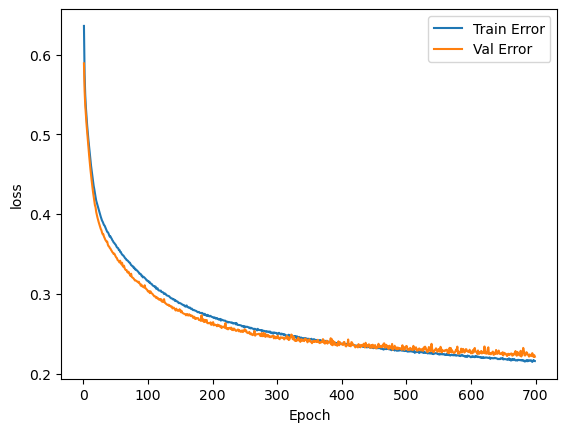

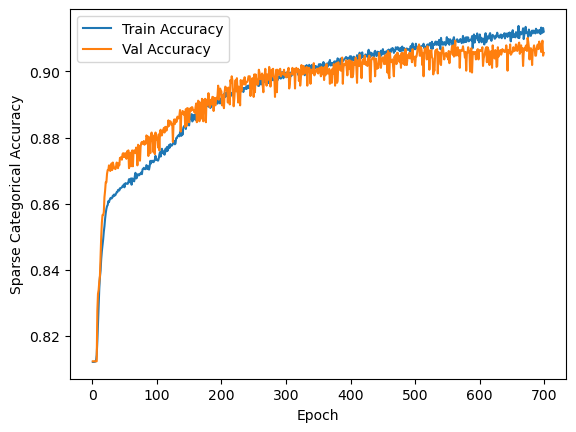

In [72]:
plot_history(hist.iloc[1:])

C:\Users\fract\AppData\Local\Temp\ipykernel_11208\817735740.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = conv_model.predict_generator(test_data)


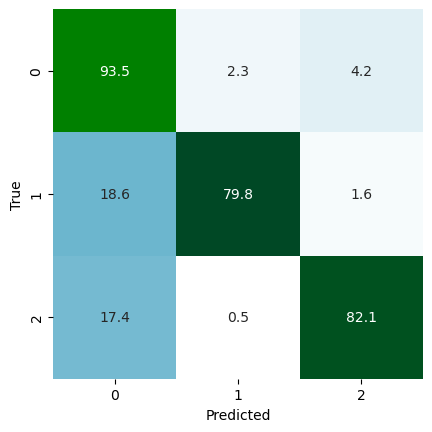

              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     12279
         1.0       0.80      0.68      0.73       944
         2.0       0.82      0.71      0.76      1896

    accuracy                           0.92     15119
   macro avg       0.85      0.79      0.82     15119
weighted avg       0.91      0.92      0.91     15119



In [73]:
predictions = conv_model.predict_generator(test_data)

y_pred = np.argmax(predictions, axis=1)
y_real = np.array(target_test)

matc=confusion_matrix(y_real, y_pred)

plotCM(y_pred, y_real, normalize=True)

print(classification_report(y_real,y_pred))

In [75]:
# save model
conv_model.save('conv_model.h5')

Observamos que los resultados de los modelos denso y convolucional de Deep Learning ofrecen resultados muy similares a los obtenidos con los modelos de Machine Learning.